In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import torch
import matplotlib.pyplot as plt
from models.gen_glm import GeneratorGLM
from utils.plot_props import PlotProps
import numpy as np

%matplotlib inline

In [3]:
generator = torch.load('..//examples//cgan_results//SharedNoise_30N_run03_gs_temp.5//generator.pt')

In [4]:
real_glm_filters = np.load('..//dataset//GLM_2D_30n_shared_noise//W.npy')
real_glm_biases = np.load('..//dataset//GLM_2D_30n_shared_noise//bias.npy')
real_w_shared_noise = .5

gen_glm_filters = generator.GLM.weight.detach().cpu().numpy().reshape(real_glm_filters.shape)
gen_glm_biases = generator.GLM.bias.detach().cpu().numpy()
gen_w_shared_noise = generator.shn_layer.weight.detach().cpu().numpy()



print(gen_glm_filters.shape, real_glm_filters.shape)

(30, 30, 40) (30, 30, 40)


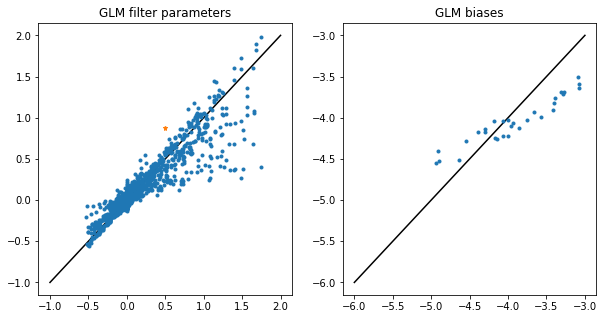

In [5]:
plot_props = PlotProps()

fig, ax = plt.subplots(1,2, figsize=(10, 5))
ax[0].set_title('GLM filter parameters')
ax[0].plot([-1, 2], [-1, 2], 'black')
ax[0].plot(real_glm_filters.flatten(), np.flip(gen_glm_filters, axis=(1, 2)).flatten(), '.')
ax[0].plot(real_w_shared_noise, gen_w_shared_noise, '*', markersize=5, label='Shared noise scale' )

ax[1].set_title('GLM biases')
ax[1].plot([-6, -3], [-6, -3], 'black')
ax[1].plot(real_glm_biases, gen_glm_biases, '.')
plt.show()

In [6]:
from utils.cgan_dataset import GanDataset
from torch.utils.data import DataLoader

FloatTensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor

spike_file = '..//dataset//GLM_2D_30n_shared_noise//data.npy'
stim_file = '..//dataset//GLM_2D_30n_shared_noise//stim.npy'
batch_size = 128

val_dataset = GanDataset(spike_file=spike_file, stim_file=stim_file,
                         stim_win_len=30, cnt_win_len=0, n_split=1, st_end=(10000, 10999))

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Shape of spike count array: (200, 999, 30)


In [7]:
from modules.gumbel_softmax_binary import GumbelSoftmaxBinary
gumbel_softmax = GumbelSoftmaxBinary(n_unit=30, gs_temp=.5)

generator.eval()

gen_data = torch.zeros([0, 0, 0, 0])
real_data = torch.zeros([0, 0, 0, 0])
n_sample = 200

for j in range(n_sample):
    temp_gen = torch.zeros([0, 0, 0])
    temp_real = torch.zeros([0, 0, 0])
    for i, inputs in enumerate(val_loader):
        cnt, stim = inputs
        batch_size = cnt.shape[0]
        real_sample = cnt.type(FloatTensor)
        stim = stim.type(FloatTensor)
        z = FloatTensor(np.random.normal(0, 1, (batch_size, generator.latent_dim)))
        fake_sample = gumbel_softmax(generator(z, stim))
        temp_gen = torch.cat((temp_gen, fake_sample))
        temp_real = torch.cat((temp_real, cnt.type(FloatTensor)))
    gen_data = torch.cat((gen_data, temp_gen.unsqueeze(0)))
    real_data = torch.cat((real_data, temp_real.unsqueeze(0)))

#gen_data = np.squeeze(gen_data.numpy())
# gen_data[gen_data > .5] = 1
# gen_data[gen_data <= .5] = 0

print(gen_data.shape, real_data.shape)

torch.Size([200, 970, 1, 30]) torch.Size([200, 970, 1, 30])


In [8]:
data = gen_data.detach().cpu().numpy().flatten()
del gen_data
print(data.shape)

(5820000,)


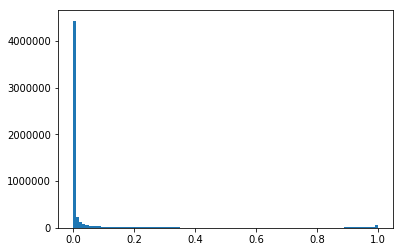

In [9]:
fig, ax = plt.subplots()
ax.hist(data, bins=100)
plt.show()